<a href="https://colab.research.google.com/github/rinocs/retinopathyTortuosityDetection/blob/master/Transfer_learning_reg_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from os.path import join
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy.random import seed
seed(42)
import numpy as np
import os
import cv2
import pandas as pd
import h5py
# import logging
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [200, 100]
%matplotlib inline  
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error, roc_auc_score

from keras.models import Sequential, Model,Input, InputLayer
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf


K.set_image_data_format('channels_last')
# import sys
# sys.path.append('content/drive/MyDrive/Colab Notebooks/tesi/myProject')
PROJECT_PATH= '/content/drive/MyDrive/Colab Notebooks/tesi/myProject/'
SKELETONS_PATH = '/content/drive/MyDrive/Colab Notebooks/tesi/myProject/sample/tort/skeletons/'
SKELETONS_NEW_PATH = '/content/drive/MyDrive/Colab Notebooks/tesi/myProject/sample/tort/skeletons_new/'
from importlib.machinery import SourceFileLoader
models = SourceFileLoader('models', join(PROJECT_PATH, 'utils/models/models.py')).load_module()

dataprepare = SourceFileLoader('dataprepare', join(PROJECT_PATH, 'utils/models/dataprepare.py')).load_module()


# from utils.models import dataprepare, models
print("lib loaded")

lib loaded


In [3]:
# kfold
k_fold = 7
kf = KFold(n_splits=k_fold)

skf = StratifiedKFold(n_splits=k_fold,random_state=7, shuffle=True)

In [4]:
df = pd.read_csv (SKELETONS_PATH+'all_tort1.csv')
# print(df)

# print(train)



In [5]:
scaler = MinMaxScaler()
df["rank"] = scaler.fit_transform(df["rank"].values.reshape(-1,1))

train, test = train_test_split(df, test_size=0.15)

In [6]:
Y = train[["rank"]].to_numpy()

In [7]:
def load_val(path, h,w):
    X_val = []
    y_val = []
    print('Read tort images')
    for index, row in val.iterrows():
        image_path = os.path.join(path, str(row['image']))
        img = cv2.resize(cv2.imread(image_path, 0), (w, h) ).astype(np.float32)
        # img = img.transpose((2,0,1))
        # img = img/255
        X_val.append(img)
        # y_val.append( [ row['VTI'] ] )
        # y_val.append( [ row['mat_distance_tort'] ] )
        y_val.append( [ row['rank'] ] )
    return X_val, y_val
def read_tort_val_data(path,  h,w):
    val_data, val_target = load_val(path,  h,w)
    val_data = np.array(val_data, dtype=np.float32)
    val_target = np.array(val_target, dtype=np.float32)
    # val_data = val_data/255
    print('tort val shape:', val_data.shape)
    print(val_data.shape[0], 'tort val samples')
    return val_data, val_target

def load_test(path, h,w):
    X_test = []
    y_test = []
    print('Read tort images')
    for index, row in test.iterrows():
        image_path = os.path.join(path, str(row['image']))
        img = cv2.resize(cv2.imread(image_path, 0), (w, h) ).astype(np.float32)
        # img = img.transpose((2,0,1))
        # img = img/255
        X_test.append(img)
        # y_test.append( [ row['mat_distance_tort'] ] )
        y_test.append( [ row['rank'] ] )
    return X_test, y_test
def read_tort_test_data(path,  h,w):
    test_data, test_target = load_test(path,  h,w)
    test_data = np.array(test_data, dtype=np.float32)
    test_target = np.array(test_target, dtype=np.float32)
    # val_data = val_data/255
    print('tort test shape:', test_data.shape)
    print(test_data.shape[0], 'tort val samples')
    return test_data, test_target





In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

def plot_preds(predicted_value, true_value):
    plt.figure(figsize=(10,10))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

  
    # p1 = np.max([np.max(predicted_value), np.max(true_value)])
    # p2 = np.min([np.min(predicted_value), np.min(true_value)])
    
    plt.plot([true_value.min(), true_value.max()], [true_value.min(), true_value.max()], 'k--',lw=4)
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()    

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def plot_roc(y_true,y_pred):
  #y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
  # Calculate roc
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

def get_model_name(k):
  return 'model_'+str(k)+'.hdf5'


caricare il nuovo dataset ( data augmentation)

In [9]:

    
#### Path 

### image parameters

image_w, image_h = 98,85
image_h1,image_w1 = 53,427
# square_size = 224
max_square_size=850
square_size = 300

In [10]:
x_test, y_test = read_tort_test_data(SKELETONS_NEW_PATH,square_size,square_size)
x_test = x_test/255

Read tort images
tort test shape: (9, 300, 300)
9 tort val samples


In [11]:

#model parameters
batch_size = 64
nb_epoch = 1000
VALIDATION_MSE = []
VALIDATION_LOSS = []
VALIDATION_RMSE =[]
VALIDATION_R2SCORE = []
TEST_R2SCORE =[]
TEST_RMSE = []
TEST_MSE = []
save_dir = '/content/drive/MyDrive/Colab Notebooks/tesi/myProject/saved_models/'

n_samples =len(Y)
filters = (16,32,64)
filters_tun = (16,32,64)
dense_layers= (256,512,256)

inputShape_new = (square_size,square_size,1)

# opt = Adam(lr=0.001, decay=1e-7)
# opt=Adam(lr=0.0001,decay=1e-7)
opt = Adam(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
datagen=ImageDataGenerator(
                           rescale=1./255,                        
                           horizontal_flip=True,
                           vertical_flip=True,
                           rotation_range=90,
                          #  zoom_range=0.15,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=0.1,
                           fill_mode="nearest",                 
                          )
val_datagen = ImageDataGenerator(
     rescale=1./255,
    #  horizontal_flip=True,
    #  vertical_flip=True,
    #  rotation_range=90,
     fill_mode="nearest"
    
    )

In [ ]:
fold_var = 1

for train_index, val_index in kf.split(np.zeros(n_samples),Y):
  training_data = train.iloc[train_index]
  validation_data = train.iloc[val_index]
  val = validation_data

  train_data_generator = datagen.flow_from_dataframe(dataframe=training_data,
                                            color_mode ="grayscale",
                                            directory=SKELETONS_NEW_PATH, x_col="image",
                                            y_col="rank",class_mode="raw",shuffle=False, seed=42,
                                            target_size=(square_size,square_size), batch_size=batch_size, interpolation="bilinear")


  valid_data_generator = val_datagen.flow_from_dataframe(dataframe=validation_data,
                                            color_mode ="grayscale",
                                            directory=SKELETONS_NEW_PATH, x_col="image",
                                            y_col="rank",class_mode="raw",shuffle=False,seed=42,
                                            target_size=(square_size,square_size), batch_size=batch_size,interpolation="bilinear")
  
  x_val, y_val = read_tort_val_data(SKELETONS_NEW_PATH,square_size,square_size)
  x_val = x_val/255

  print("=========================================")
  print("====== K Fold Validation step => %d/%d =======" % (fold_var,k_fold))
  print("=========================================")


  try:

    model = models.create_cnn_custom(image_w, image_h, 1,filters,256,256, regress=True)
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/tesi/myProject/checkpoint/weights_23Sesec.hdf5')

    tuning_model =  models.create_tuning_model(square_size, square_size, 1,filters_tun,dense_layers, regress=True)
  except Exception as e:
    print(e)
    pass
  # print(model.summary())
  for i in range(1, len(model.layers)-8):
    ww = model.layers[i].get_weights()
    tuning_model.layers[i].set_weights(ww)
 
  tuning_model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mse'])
  # model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mse'])
  # tuning_model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mae'])

  #using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
  earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #save the best model with lower validation loss
  # checkpointer = ModelCheckpoint(save_dir+get_model_name(fold_var), verbose=1, save_best_only=True, save_weight_only=True)
  checkpointer = tf.keras.callbacks.ModelCheckpoint(
            save_dir+get_model_name(fold_var),
            verbose=1,
            save_weights_only=True,
            save_best_only=True,
        )  
  # tf.keras.experimental.export_saved_model(model, 'path_to_my_model.h5')
   
  callback_list = [  earlystopping,checkpointer]

  history = tuning_model.fit(train_data_generator,
              batch_size=batch_size,
              # steps_per_epoch = train_data_generator.samples // batch_size,
              #  steps_per_epoch=len(x_train)// batch_size,
              #validation_steps=len(x_val)//batch_size,
              validation_data= (x_val,y_val),
              # validation_data= valid_data_generator,
              # validation_steps = valid_data_generator.samples // batch_size,
              epochs=nb_epoch,
              shuffle=True,
              callbacks=callback_list,
              verbose=2)  
    

  
  tuning_model.load_weights(save_dir+"model_"+str(fold_var)+".hdf5")
  results = tuning_model.evaluate(valid_data_generator)

  results = dict(zip(tuning_model.metrics_names,results))
  test_rmse = mean_squared_error(y_test, tuning_model.predict(x_test), squared=False)
  test_mse = mean_squared_error(y_test, tuning_model.predict(x_test))
  VALIDATION_R2SCORE.append( r2_score(y_val,tuning_model.predict(x_val) ))
  
  
   
  VALIDATION_MSE.append(results['mse'])
  VALIDATION_LOSS.append(results['loss'])
  TEST_RMSE.append(test_rmse)
  TEST_MSE.append(test_mse)
  TEST_R2SCORE.append(r2_score(y_test,tuning_model.predict(x_test) ))
  tf.keras.backend.clear_session()

  fold_var += 1



Found 43 validated image filenames.
Found 8 validated image filenames.
Read tort images
tort val shape: (8, 300, 300)
8 tort val samples
====== K Fold Validation step => 1/7 =======
Epoch 1/1000
1/1 - 2s - loss: 4.4008 - mse: 4.4008 - val_loss: 19.7471 - val_mse: 19.7471

Epoch 00001: val_loss improved from inf to 19.74711, saving model to /content/drive/MyDrive/Colab Notebooks/tesi/myProject/saved_models/model_1.hdf5
Epoch 2/1000
1/1 - 1s - loss: 14.3665 - mse: 14.3665 - val_loss: 2.8720 - val_mse: 2.8720

Epoch 00002: val_loss improved from 19.74711 to 2.87199, saving model to /content/drive/MyDrive/Colab Notebooks/tesi/myProject/saved_models/model_1.hdf5
Epoch 3/1000
1/1 - 1s - loss: 3.2974 - mse: 3.2974 - val_loss: 1.7507 - val_mse: 1.7507

Epoch 00003: val_loss improved from 2.87199 to 1.75069, saving model to /content/drive/MyDrive/Colab Notebooks/tesi/myProject/saved_models/model_1.hdf5
Epoch 4/1000
1/1 - 1s - loss: 6.6432 - mse: 6.6432 - val_loss: 1.4343 - val_mse: 1.4343

Epoc

In [18]:

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(VALIDATION_MSE)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {VALIDATION_LOSS[i]} - MSE: {VALIDATION_MSE[i]} - VAL_R2SCORE: {VALIDATION_R2SCORE[i]} - TEST_RMSE: {TEST_RMSE[i]} - TEST_MSE: {TEST_MSE[i]}- TEST_R2SCORE: {TEST_R2SCORE[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(VALIDATION_MSE)} (+- {np.std(VALIDATION_MSE)})')
print(f'> Loss: {np.mean(VALIDATION_LOSS)}')
print(f'> TEST_RMSE: {np.mean(TEST_RMSE)}')
print(f'> TEST_MSE: {np.mean(TEST_MSE)}(+- {np.std(TEST_MSE)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.09810902178287506 - MSE: 0.09810902178287506 - VAL_R2SCORE: -0.8985226773561013 TEST_RMSE: 0.9205241203308105 - TEST_MSE: 0.8473646640777588- TEST_R2SCORE: -8.373729559911295
------------------------------------------------------------------------
> Fold 2 - Loss: 0.050928860902786255 - MSE: 0.050928860902786255 - VAL_R2SCORE: -7.460022876514358 TEST_RMSE: 0.9187121391296387 - TEST_MSE: 0.8440319895744324- TEST_R2SCORE: -8.336863614477487
------------------------------------------------------------------------
> Fold 3 - Loss: 0.15945720672607422 - MSE: 0.15945720672607422 - VAL_R2SCORE: -5.900502486150353 TEST_RMSE: 0.7539746761322021 - TEST_MSE: 0.5684778094291687- TEST_R2SCORE: -5.288623648648257
------------------------------------------------------------------------
> Fold 4 - Loss: 0.1369095891714096 - 

IndexError: ignored

Loading weights

NameError: ignored

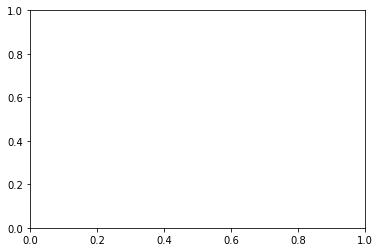

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, preds,alpha=0.3, c='blue')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Test dataset')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_preds,alpha=0.4, c='blue')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],"k--", lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Train dataset')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_val, val_preds,alpha=0.4, c='blue')
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=7)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Val dataset')
plt.show()

In [ ]:
xValues = range(0, len(y_test_df))
test_mse = mean_squared_error(y_test_df, preds)
fig, ax = plt.subplots()
ax.scatter(xValues , y_test_df, c='blue')
ax.scatter(xValues, preds, c='red')
# ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=7)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('test dataset, MSE: '+ str(test_mse))
plt.show()

In [ ]:
xValues = range(0, len(y_train))
print(np.mean(y_train))
fig, ax = plt.subplots()
ax.scatter(xValues , y_train, alpha=0.4,c='blue')
ax.scatter(xValues, train_preds, c='red')
# ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=7)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('train dataset')
plt.show()

In [ ]:
xValues = range(0, len(y_val_df))
# print(np.mean(y_val_df))
val_mse = mean_squared_error(y_val_df, val_preds)
fig, ax = plt.subplots()
ax.scatter(xValues , y_val_df, c='blue')
ax.scatter(xValues, val_preds, c='red')
# ax.plot([y_val_df.min(), y_val_df.max()], [y_val_df.min(), y_val_df.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('val dataset, mse:'+ str(val_mse))
plt.show()

In [ ]:
plt.figure(figsize=[3, 3])
plt.scatter(y_train.flatten(), train_preds.flatten(), alpha=0.4, c='blue')

plt.title('Train dataset')

In [ ]:
plt.figure(figsize=[3, 3])
plt.scatter(y_test.flatten(), preds.flatten(), alpha=0.4, c='blue')

plt.title('Train dataset')